# Persistence 
This notebook is for plotting:

- **Figure 5**: Changes in the length of Persistent Energy Droughts (PEDs) in winter (December-February) for two different typed of PEDs
- **Supplementary Figure 5**: Changes in the length of Persistant Energy Droughts (PEDs) in summer (June-August)
requires running select_PEDs.py first

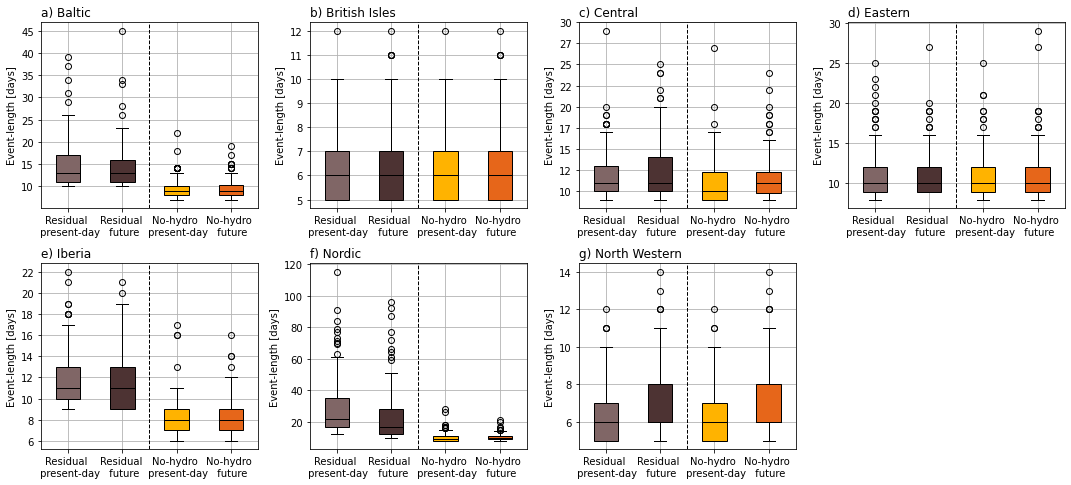

/usr/people/most/03_project3/img/winter_peristance.png
BAL         1.0
BRI         1.0
CEN         1.1
EAS         1.0
IBA         1.0
NRD    1.111111
NWE         1.0
dtype: object
BAL         1.0
BRI         1.0
CEN         1.0
EAS         1.0
IBA         1.0
NRD    0.772727
NWE         1.0
dtype: object


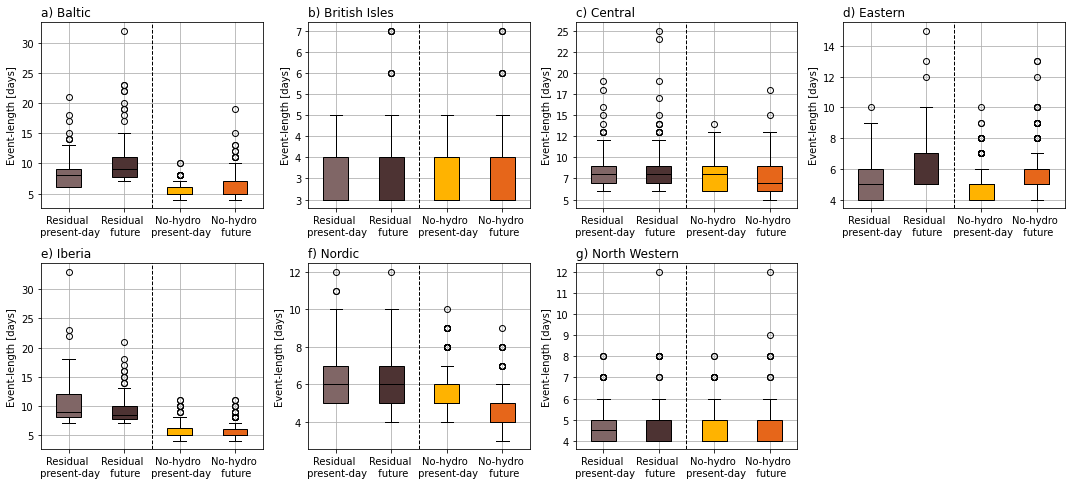

/usr/people/most/03_project3/img/summer_peristance.png
BAL      1.0
BRI      1.0
CEN    0.875
EAS      1.0
IBA      1.0
NRD      0.8
NWE      1.0
dtype: object
BAL       1.125
BRI         1.0
CEN         1.0
EAS         1.0
IBA    0.944444
NRD         1.0
NWE    0.888889
dtype: object


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Define keys and mappings
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']
abr = ['NRD', 'BRI', 'NWE', 'CEN', 'IBA', 'BAL', 'EAS']
mapping = dict(zip(abr, keys))

# Define color scheme
colors = [
    [(1.0, 0.7, 0.0), (0.9, 0.4, 0.1)], 
    [(0.4, 0.9, 0.2), (0.3, 0.6, 0.1)], 
    [(0.2, 0.4, 1), (0.2, 0.3, 0.6)],
    [(0.6, 0.2, 0.9), (0.5, 0.1, 0.7)],
    [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]
]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

# Load datasets
folder = # input folder
when = "winter"  # Example: 'winter'. Adjust as necessary.

for when in ['winter', 'summer']:
    # Read CSVs
    df0_pd = pd.read_csv(f'{folder}residual_pvwind_q0.97_{when}_daygap3_PD_project3.csv')
    df0_fu = pd.read_csv(f'{folder}residual_pvwind_q0.97_{when}_daygap3_FU_project3.csv')
    df1_pd = pd.read_csv(f'{folder}residual_q0.97_{when}_daygap3_PD_project3.csv')
    df1_fu = pd.read_csv(f'{folder}residual_q0.97_{when}_daygap3_FU_project3.csv')

    # Process datasets
    def process_event_length(df):
        return df.groupby(['country', 'event_nr'])[['nr_of_days']].first().rename({'nr_of_days': 'event_length'}, axis=1)

    # Apply processing
    event_length_pd_0 = process_event_length(df0_pd)
    event_length_fu_0 = process_event_length(df0_fu)
    event_length_pd_1 = process_event_length(df1_pd)
    event_length_fu_1 = process_event_length(df1_fu)

    # Combine datasets
    def combine_datasets(pd_data, fu_data, label_pd, label_fu):
        pd_data['Timeframe'], fu_data['Timeframe'] = label_pd, label_fu
        return pd.concat([pd_data, fu_data])

    name_event2 = 'No-hydro'
    combined_0 = combine_datasets(event_length_pd_0, event_length_fu_0, f'{name_event2} \n present-day', f'{name_event2} \n future')
    combined_1 = combine_datasets(event_length_pd_1, event_length_fu_1, 'Residual \n present-day', 'Residual \n future')

    # Plotting setup
    countries = combined_0.index.get_level_values('country').unique()
    num_countries = len(countries)
    nrows, ncols = 2, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))
    plt.suptitle(f'{when} event length frequency')
    means = pd.DataFrame(columns=['No-hydro \n future', 'No-hydro \n present-day', 'Residual \n future',
   'Residual \n present-day'])
    # Loop through countries and plot
    for j, ax, country in zip(range(num_countries), axes.flat, countries):
        data_0 = combined_0.xs(country, level='country')
        data_1 = combined_1.xs(country, level='country')

        data_combined = pd.concat([data_1, data_0])
        
        data_combined['Timeframe'] = pd.Categorical(data_combined['Timeframe'], 
                                                    categories=['Residual \n present-day', 'Residual \n future', 
                                                                f'{name_event2} \n present-day', f'{name_event2} \n future'], 
                                                    ordered=True)

        boxplot = data_combined.boxplot(column='event_length', by='Timeframe', ax=ax, patch_artist=True, return_type='dict')

        # Manually color boxplots
        colors = [*colors_dict['residual'], *colors_dict['pv']]
        for patch, color in zip(boxplot['event_length']['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')

        # Style plot elements
        outline_color = 'black'
        for median in boxplot['event_length']['medians']:
            median.set_color(outline_color)
        for whisker in boxplot['event_length']['whiskers']:
            whisker.set_color(outline_color)
            whisker.set_linewidth(1)
        for cap in boxplot['event_length']['caps']:
            cap.set_color(outline_color)
            cap.set_linewidth(1)

        # Set title and labels
        ax.set_title("") # first clear default title
        subplot_nr = f"{chr(97 + j)})"
        ax.set_title(f'{subplot_nr} {mapping[country]}', loc='left')
        ax.set_xlabel('')
        ax.set_ylabel('Event-length [days]')

        # Add vertical line
        ax.axvline(2.5, color='black', linestyle='--', linewidth=1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
        
        # add percentage changes
        means.loc[country, :] = data_combined.groupby("Timeframe").median().T.iloc[0]
  
    # Remove empty subplots
    for i in range(num_countries, nrows * ncols):
        fig.delaxes(axes.flat[i])

    # Final adjustments
    fig.suptitle('')
    plt.tight_layout()

    # Save and show the figure
    oname = f'{when}_peristance.png'
    plt.savefig(oname, dpi=300, bbox_inches='tight')
    plt.show()

    print(oname)
    print(means['No-hydro \n future']/means['No-hydro \n present-day'])
    print(means['Residual \n future']/means['Residual \n present-day'])
      

BAL      1.0
BRI      1.0
CEN    0.875
EAS      1.0
IBA      1.0
NRD      0.8
NWE      1.0
dtype: object


BAL       1.125
BRI         1.0
CEN         1.0
EAS         1.0
IBA    0.944444
NRD         1.0
NWE    0.888889
dtype: object